<a href="https://colab.research.google.com/github/JEN6YT/APS360/blob/main/Jennifer_Lab5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1VZjl01M7BIukPKH6WvQtHl6OCnrq3Axi

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [1]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 821.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == 's':
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
# the label value for spam is "spam" and the label value for a non-spam is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_nonspam = 0
count_spam = 0
for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    count_nonspam += 1
  else:
    count_spam += 1
  
print("the number of spam messages is", count_spam, "and the number of non-spam messages is", count_nonspam)

the number of spam messages is 747 and the number of non-spam messages is 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# the advantages of modelling the messages as a sequence of characters are:
# first, it there are far fewer characters than words in English language, so the total memory for storing
# the tokens will be less and thus less memory requirement.
# second, the chance of seeing an unknown word is much higher than seeing an unknown character, 
# so the model is able to generalize better by learning characters

# the disadvantages of modelling the messages as a sequence of characters are:
# first, it takes more time and more compute to train the model since there is more characters than words
# in a sentence. 
# second, since the meaning of the sentences depend on the relationship between words, if we are only 
# focusing on each single character, it is harder to extract meaningful relationship in the sentences, or grasp 
# a better understanding of the whole sentence. 

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [3]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [4]:
# having a balanced training set is helpful because given a test example, there is an equal probability of outputting
# any of the classes. in order to achieve high accuracy, the network has to learn how to identify each class, and
# thus it becomes more robust. for example, the network will learn to classify both spam and non-spam messages. 
# for an imbalanced training set, it is much probable that the output will likely be the class which appears the most
# in the training dataset. for example, the network in our example can just achieve very high accuracy by outputting 
# 'non-spam' no matter what the input is.

In [5]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [8]:
text_field.build_vocab(train)
# text_field.vocab.stoi: it a dictionary that maps all the characters to an integer identifier that represents
# the character
print(text_field.vocab.stoi) 
# text_field.vocab.itos: it is a list that documents all the characters appeared in the list of tokens in the order
# of their respective integer identifier
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fc8bf39b580>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'C': 34, 'I': 35, 'O': 36, '4': 37, 'N': 38, 'x': 39, 'A': 40, '6': 41, '7': 42, '3': 43, 'R': 44, ',': 45, '!': 46, '9': 47, 'P': 48, 'W': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'D': 54, 'G': 55, 'F': 56, 'B': 57, 'Y': 58, '?': 59, "'": 60, '/': 61, '£': 62, '&': 63, '-': 64, ':': 65, 'z': 66, 'X': 67, 'V': 68, '*': 69, 'K': 70, 'j': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'q': 77, 'Q': 78, '#': 79, '"': 80, '@': 81, '=': 82, 'ü': 83, '>': 84, 'Z': 85, 'Ü': 86, '\x92': 87, '$': 88, '%': 89, '_': 90, '‘': 91, '|': 92, '¡': 93, '“': 94, '[': 95, ']': 96, '–': 97, '\x93': 98,

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> means unknown, and it represents a word that does not appear in the dictionary
# <pad> is a token that increase the size of SMS messages so all the messages in a batch have the same length 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [10]:
i = 0
padcount = 0
maxlength = 0
length = []
pad = []

# print(batch.sms[0])
# print(batch.label)

for batch in train_iter:
  if i<10:
    for sms in batch.sms[0]:
      if len(sms) > maxlength:
        maxlength = len(sms)
      for token in sms:
        if token == text_field.vocab.stoi['<pad>']:
          padcount+=1
    length.append(maxlength)
    maxlength = 0
    pad.append(padcount)
    padcount = 0
    i += 1

print(length)  
print(pad)

[69, 32, 158, 157, 202, 41, 108, 17, 137, 112]
[14, 38, 23, 0, 599, 31, 56, 189, 28, 53]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [9]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [11]:
class rnn(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers=1):
    super(rnn, self).__init__()

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(input_size)

    # recurrent neural network
    self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)

    # a fully-connected layer that classifies the input into SPAM/HAM
    self.fc = nn.Linear(hidden_size, 2) 

  def forward(self, x):
    one_hot = []
    for sms in x:
      one_hot.append(self.ident[sms])   # generate one-hot vectors of input

    input = torch.stack(one_hot)
    
    output, _ = self.rnn(input)           # get the next output and hidden state
    out =  torch.max(output, dim=1)[0]    # max pooling the GRU output
    out = self.fc(out)
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [15]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [16]:
import matplotlib.pyplot as plt

def train_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        
        losses.append(float(loss))
        epochs.append(epoch+1)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.666621; Train Acc 0.726000; Val Acc 0.553363
Epoch 2; Loss 0.635452; Train Acc 0.943191; Val Acc 0.927354
Epoch 3; Loss 0.564454; Train Acc 0.901696; Val Acc 0.958744
Epoch 4; Loss 0.182452; Train Acc 0.938910; Val Acc 0.953363


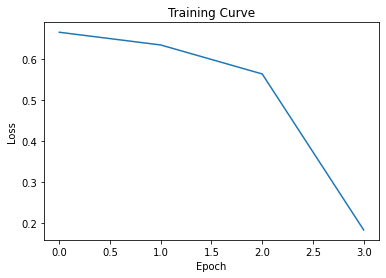

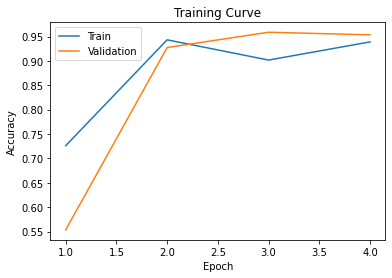

In [23]:
valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

myrnn = rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train_network(myrnn, train_iter, valid_iter, num_epochs=4, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# there are a coule of parameters that needs to be tuned. 
# tuning the number of epoches, learning rate, number of layers in the GRU layer, 

# First, increase the number of layers in the GRU (to 2) with number of epochs 10
# Results: Epoch 10; Loss 0.347943; Train Acc 0.957642; Val Acc 0.953363

# The performance was very good, and it didn't appear to overfit the training set since the validation 
# accuracy was as good (if not better) than the training accuracy for most of the epochs.

# Second, a higher learning rate (5e-4)
# Results: Epoch 10; Loss 0.375822; Train Acc 0.845; Val Acc 0.8307
# it appeared to converge at around 5 epochs and the other 5 epochs past that were overfitting 
# with just extremely small gains in accuracy. 

# Third, choosing the number of epoches to be 5 epochs this time.
# Results: Epoch 5; Loss 0.314648; Train Acc 0.960598; Val Acc 0.963229
# I decided to go with this model since it was just marginally below the numbers of the previous model, 
# but it was trained significantly less so it's less likely to be overfitted to the training data. 

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [18]:
# Create a Dataset of only spam validation examples (negative labels)
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples (positive labels)
valid_nonspam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nonspam_iter = torchtext.legacy.data.BucketIterator(valid_nonspam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [19]:
# validation false negative
print(1- get_accuracy(rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2), valid_spam_iter))

# validation false positive
print(1- get_accuracy(rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2), valid_nonspam_iter))

0.0
0.004149377593360981


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# the false positive means that the algorithm detects a spam but there is no spam, so the phone might block 
# the sender of the message. however, the message might be really important
# the false negative means that the algorithm does not detect a spam but there is spam, so the phone use might
# receive a spam message, which can be annoying

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [26]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

get_accuracy(rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2), test_iter)

0.8635547576301615

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [21]:
# Create a Dataset of only spam validation examples (negative labels)
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples (positive labels)
test_nonspam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nonspam_iter = torchtext.legacy.data.BucketIterator(test_nonspam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [31]:
# test false negative
print(1- get_accuracy(rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2), test_spam_iter))

# test false positive
print(1- get_accuracy(rnn(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2), test_nonspam_iter))

0.36170212765957444
0.0


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [33]:
msg = "machine learning is sooo cool!"
token = []
for i in msg:
  token.append(torch.tensor(text_field.vocab.stoi[i]))

input = torch.stack(token)
input.unsqueeze_(0)

F.softmax(myrnn(input), dim=1)[0][1].item()

0.31535351276397705

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# Naive Bayes spam filtering can be a baseline technique for dealing with spam that can tailor itself 
# to the email needs of individual users and give low false positive spam detection rates that are generally 
# acceptable to users.

# To build a Naive Bayes classifier
# Step 1: Calculate the prior probability for given class labels
# Step 2: Find Likelihood probability with each attribute for each class
# Step 3: Put these value in Bayes Formula and calculate posterior probability.
# Step 4: See which class has a higher probability, given the input belongs to the higher probability class.
